In [3]:
# Di Google Colab
from google.colab import files
uploaded = files.upload() # Upload file kaggle.json Anda

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset IAM Handwriting
!kaggle datasets download -d landlord/handwriting-recognition
!unzip handwriting-recognition.zip -d data/

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/landlord/handwriting-recognition
License(s): CC0-1.0
handwriting-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  handwriting-recognition.zip
replace data/test_v2/test/TEST_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install opencv-python
!pip install keras
!pip install tensorflow

In [4]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [5]:
train = pd.read_csv('/content/data/written_name_train_v2.csv')
valid = pd.read_csv('/content/data/written_name_validation_v2.csv')

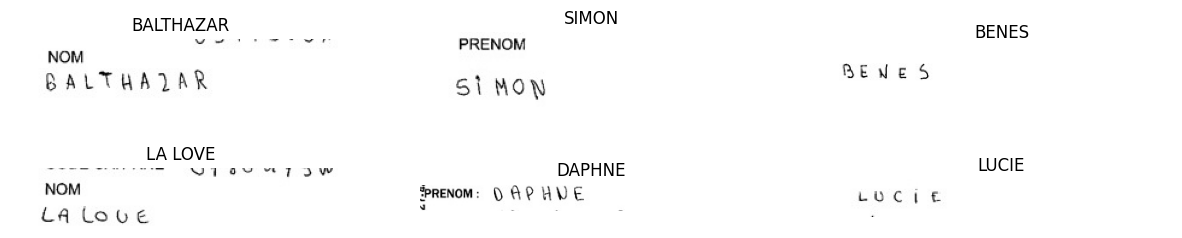

In [6]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/data/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [7]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [8]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

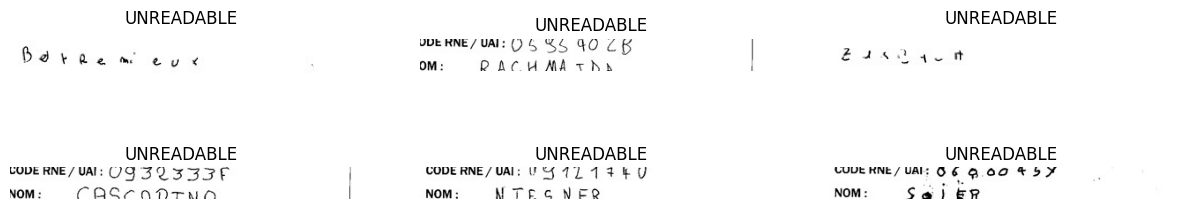

In [9]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/data/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [10]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [11]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [12]:
train.reset_index(inplace = True, drop=True)
valid.reset_index(inplace = True, drop=True)

In [13]:
def preprocess(img):
    (h, w) = img.shape

    final_img = np.ones([64, 256])*255 # blank white image

    # crop
    if w > 256:
        img = img[:, :256]

    if h > 64:
        img = img[:64, :]


    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [14]:
train_size = 21000
valid_size= 2100

In [15]:
train_x = []

for i in range(train_size):
    img_dir = '/content/data/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [16]:
valid_x = []

for i in range(valid_size):
    img_dir = '/content/data/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [17]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [18]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))

    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [19]:
name = 'NAUFAL'
print(name, '\n',label_to_num(name))

NAUFAL 
 [13  0 20  5  0 11]


In [20]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])

In [21]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])

In [22]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100],
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


In [23]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 256, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 256, 64, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max1 (MaxPooling2D)             │ (None, 128, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 128, 32, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 32, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2 (MaxPooling2D)             │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 64, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max3 (MaxPooling2D)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64, 64)         │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm1 (Bidirectional)           │ (None, 64, 512)        │       657,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (Bidirectional)           │ (None, 64, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64, 30)         │        15,390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 64, 30)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,406,878 (9.18 MB)

 Trainable params: 2,406,430 (9.18 MB)

 Non-trainable params: 448 (1.75 KB)

In [24]:
from tensorflow.keras.backend import ctc_batch_cost # Import from TensorFlow Keras backend
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    # Use the imported ctc_batch_cost directly
    return ctc_batch_cost(labels, y_pred, input_length, label_length)


In [25]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [27]:
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output,
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=30, batch_size=128)

Epoch 1/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 54s 283ms/step - loss: 38.1586 - val_loss: 22.5457
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 81s 276ms/step - loss: 20.3632 - val_loss: 20.4167
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 82s 274ms/step - loss: 20.0744 - val_loss: 20.1293
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 82s 277ms/step - loss: 19.8068 - val_loss: 19.7565
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 82s 276ms/step - loss: 19.4814 - val_loss: 19.4426
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 46s 278ms/step - loss: 19.1075 - val_loss: 18.8171
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 45s 274ms/step - loss: 18.7041 - val_loss: 18.1787
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 46s 277ms/step - loss: 17.8907 - val_loss: 17.6643
Epoch 9/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 83s 281ms/step - loss: 17.0363 - val_loss: 16.6650
Epoch 10/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 81s 274ms/step - loss: 15.9572 - val_loss: 15.4164
Epoch 11/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 46s 278ms/step - loss: 14.7779 - val_loss: 13.97

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K # Import Keras backend from TensorFlow

preds = model.predict(valid_x)
# Use tf.keras.backend.get_value instead of K.get_value
decoded = tf.keras.backend.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1],
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [30]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)

    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr :
        correct += 1

print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 63.14%
Correct words predicted      : 40.43%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


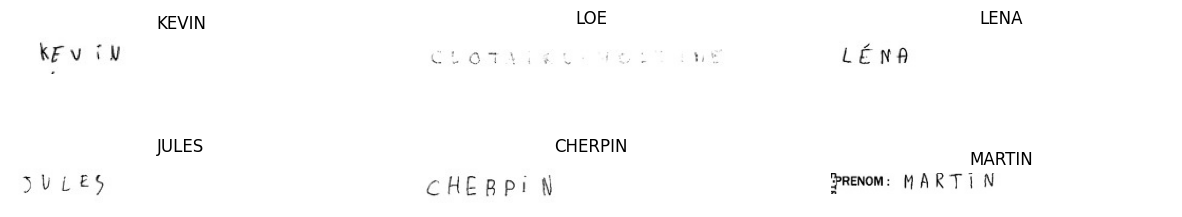

In [32]:
test = pd.read_csv('/content/data/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/data/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')

    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [34]:
from keras.models import save_model

# Save the model using the recommended .keras format
save_model(model, "/content/model/model.keras")